#### listening code

In [ ]:
# listening test
from IPython.display import Audio

Audio(data=audio_file, rate=22050, autoplay=True)


# Stratified 5-fold cross-validation (not grouped)

### imports

In [ ]:
# install
!pip install librosa
!pip install pyloudnorm
!pip install pedalboard


# imports and constants
import pyloudnorm as pyln
import librosa
from IPython.display import Audio
import pyloudnorm as pyln
import pickle
import numpy as np
import os
import random
import gc
from pprint import pprint


# constants
DATA_PATHS_EMOTIONS = r'C:/Users/miche/Desktop/guitar_emotion_info/listening-test-results/listen_audio_paths_emotions.pickle'
files_each_emotion = [96, 116, 77, 98]   # ['aggressive', 'relaxed', 'happy', 'sad']
SAMPLING_RATE = 22050
SEGMENT_LENGTH = SAMPLING_RATE * 3  # 66150
EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']


# functions
def normalize_loudness(audio_file, sr, loudness_level=-26, verbose=False):
    # create BS.1770 meter and get audio loudness
    meter = pyln.Meter(sr)
    loudness = meter.integrated_loudness(audio_file)
    # loudness normalize to -26 dB LUFS
    loudness_normalized_audio = pyln.normalize.loudness(audio_file, loudness, loudness_level)
    if verbose:
        print(f"\nDETAILS OF normalized_audio FUNCTION\n"
              f"- old loudness: {loudness}\n"
              f"- new loudness: {meter.integrated_loudness(loudness_normalized_audio)}")
    return loudness_normalized_audio

###Prepare Dataset

In [ ]:
# constants and functions

FIVE_FOLDS_AUDIO_SEGMENTS = r"/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/five_folds_audio_segments_list_dict.pickle"

#in this path we find is a list of 5 dictionaries like this:
#dict = {
#    'spectrogram': [[seg1, seg2, seg3], [], [], ..],
#    'label': [],
#    'name': [] }


def create_train_test_audio_segments(train_folds, test_fold, data_segments):
    '''get the data of the entire dataset and create train set (4 folds) and test set (1 fold)
    as output we get the spectrograms associated with their label and the name of the song'''
    # TRAINING SET - concatenate all the segments in each of the 4 folds used for the training
    # es [ [seg_1a, seg_2a, seg_3a], [seg_1b, seg_2b],] ... ] ->  [seg_1a, seg_2a, seg_3a, seg_1b, seg_2b, ...]
    #    [ 2,                        0,                  ...] ->  [2, 2, 2, 0, 0, ...]
    X_train_audio = []
    y_train = []
    N_train = []
    for i in train_folds:
        # list_spec = [ [seg1, seg2, seg3], [], [], ...]
        # label =    [ 0, 2, 3, ...]
        # name =     [ 16_happy_i.., 146_aggres.., ...]
        for list_segm, label, name in zip(data_segments[i]['segments'], data_segments[i]['label'], data_segments[i]['name']):
            #print(len(list_segm), label, name)
            for segm in list_segm:
                X_train_audio.append(segm)
                y_train.append(label)
                N_train.append(name)
    # TEST SET
    X_test_audio = []
    y_test = []
    N_test = []
    for list_segm, label, name in zip(data_segments[test_fold]['segments'], data_segments[test_fold]['label'], data_segments[test_fold]['name']):
        #print(len(list_segm), label, name)
        for segm in list_segm:
            X_test_audio.append(segm)
            y_test.append(label)
            N_test.append(name)
    return X_train_audio, y_train, N_train, X_test_audio, y_test, N_test


def convert_audo_in_spectrograms(X_data_audio, y_data):
    # convert audio files in spectrograms
    X_data = []  # mel spectrograms
    for audio_segment in X_data_audio:
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_segment, sr=SAMPLING_RATE, n_fft=2048, hop_length=512, n_mels=128)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)  # I could add: log_mel_spectrogram = log_mel_spectrogram.T
        X_data.append(log_mel_spectrogram)
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    return X_data, y_data


def get_train_test_folds(test_fold):
    # ex return -> ( [0, 1, 2, 4], 3 )
    train_folds = [0, 1, 2, 3, 4]
    train_folds.remove(test_fold)
    return train_folds, test_fold

## Classification - libraries and functions

In [ ]:
import pickle
import numpy as np
import librosa
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import gc


INPUT_SHAPE = (128, 130, 1)
EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']


def normalize_spectrogram(matrix):
    """normalizes between 0 and 1"""
    min = np.min(matrix)
    max = np.max(matrix)
    new_matrix = (matrix - min) / (max - min)
    return new_matrix

def standardize_spectrogram(matrix):
    mean = np.mean(matrix)
    std = np.std(matrix)
    new_matrix = (matrix - mean) / std
    return new_matrix

# build and train a CNN
def build_model(input_shape):
    # create model
    model = keras.Sequential()
    # 1st conv layer
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 2nd conv layer
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 3rd conv layer
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 4th conv layer
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten the output and feed into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    # output layer
    model.add(keras.layers.Dense(4, activation='sigmoid'))
    model.summary()
    return model


def compile_model(model, learning_rate=0.001):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])
    return model

def train(model, X_train, y_train, X_test, y_test, epochs, batch_size):
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        print('epoch:', epoch+1)
        model.fit(X_train, y_train, epochs=1, batch_size=batch_size, shuffle=True)

        train_loss, train_accuracy =  model.evaluate(X_train, y_train, verbose=0)
        train_accuracies.append(train_accuracy)

        test_loss, test_accuracy =  model.evaluate(X_test, y_test, verbose=0)
        test_accuracies.append(test_accuracy)
        print(f'- train acc: {train_accuracy},  - test acc: {test_accuracy}')

    return train_accuracies, test_accuracies


def get_fused_accuracy(data_segments, test_fold, model, standardize=False, Print=False):

    predictions = []
    true_labels = []

    for list_segm, label, name in zip(data_segments[test_fold]['segments'], data_segments[test_fold]['label'], data_segments[test_fold]['name']):

        #print(len(list_segm), label, name)
        mel_specs = []
        segment_predictions = []

        # consider each segment of the current song
        for audio_segm in list_segm:

            # get mel spec for each segment
            mel_spec = librosa.feature.melspectrogram(y=audio_segm, sr=SAMPLING_RATE, n_fft=2048, hop_length=512, n_mels=128)
            log_mel_spec = librosa.power_to_db(mel_spec)
            if standardize:
                log_mel_spec = standardize_spectrogram(log_mel_spec)
            mel_specs.append(log_mel_spec)

        # make prediction for all the specs in a given song
        mel_specs = np.array(mel_specs)
        pred = model.predict(mel_specs, verbose=0)

        # sum predictions of each segmnt in a song
        song_pred = np.sum(pred, axis=0)   # eg. [ 11.0, 0.03, 0.01, 1.9 ]
        pred_label = np.argmax(song_pred)         # eg. 0

        # save predictions and true labels
        predictions.append(pred_label)
        true_labels.append(label)

        # print information for each song
        if Print:
            print('song:', name)
            print('score values:', np.round(song_pred, 3))
            print('prediction: ', pred_label , '-> ',EMOTIONS[pred_label])
            print('true label: ', label, '-> ',EMOTIONS[label], end='\n\n')

    return predictions, true_labels, accuracy_score(predictions, true_labels)


def plot_conf_matrix(y_true, y_pred, save_path=False):
    disp = ConfusionMatrixDisplay.from_predictions(y_true=y_true,
                                                   y_pred=y_pred,
                                                   display_labels=EMOTIONS,
                                                   cmap='Blues',
                                                   xticks_rotation='vertical',
                                                   normalize='true')
    if save_path!=False:
        plt.savefig(save_path, bbox_inches='tight')

    plt.grid(False)
    plt.show()

## Data augmentation

In [ ]:
def pitch_shift_augmentation(X_train_audio, y_train):
    X_train_aug = []
    y_train_aug = []

    for sample, label in zip(X_train_audio, y_train):

        # keep the original sample
        X_train_aug.append(sample)
        y_train_aug.append(label)

        #create two samples for each audio sample
        for interval in [-2, -1, 1,  2]:
            augmented_sample = librosa.effects.pitch_shift(y=sample, sr=SAMPLING_RATE, n_steps=interval)
            X_train_aug.append(augmented_sample)
            y_train_aug.append(label)

    X_train_aug = np.array(X_train_aug)
    y_train_aug = np.array(y_train_aug)

    return X_train_aug, y_train_aug



def time_stretch(X_train_audio, y_train):
    X_train_aug = []
    y_train_aug = []

    for sample, label in zip(X_train_audio, y_train):

        # keep the original sample
        X_train_aug.append(sample)
        y_train_aug.append(label)

        #create two samples for each audio sample
        for interval in [0.95, 0.98]:

            augmented_sample = librosa.effects.time_stretch(y=sample, rate=interval)
            augmented_sample = augmented_sample[:len(sample)]

            X_train_aug.append(augmented_sample)
            y_train_aug.append(label)

    X_train_aug = np.array(X_train_aug)
    y_train_aug = np.array(y_train_aug)

    return X_train_aug, y_train_aug


def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal


def noise_addition(X_train_audio, y_train):
    X_train_aug = []
    y_train_aug = []

    for sample, label in zip(X_train_audio, y_train):

        # keep the original sample
        X_train_aug.append(sample)
        y_train_aug.append(label)

        #create two samples for each audio sample
        for interval in [0.02, 0.05]:

            augmented_sample = add_white_noise(signal=sample, noise_percentage_factor=interval)

            X_train_aug.append(augmented_sample)
            y_train_aug.append(label)

    X_train_aug = np.array(X_train_aug)
    y_train_aug = np.array(y_train_aug)

    return X_train_aug, y_train_aug


def change_gain(X_train_audio, y_train):
    X_train_aug = []
    y_train_aug = []

    for sample, label in zip(X_train_audio, y_train):

        # keep the original sample
        X_train_aug.append(sample)
        y_train_aug.append(label)

        #create two samples for each audio sample
        for value in [0.8, 1.2]:

            augmented_sample = augmented_signal = sample * value

            X_train_aug.append(augmented_sample)
            y_train_aug.append(label)

    X_train_aug = np.array(X_train_aug)
    y_train_aug = np.array(y_train_aug)

    return X_train_aug, y_train_aug


# guitar effects
from pedalboard import Pedalboard, Chorus, Reverb, Distortion, Phaser, Delay, load_plugin

def guitar_effect(X_train_audio, y_train, effect, values):

    X_train_aug = []
    y_train_aug = []

    for sample, label in zip(X_train_audio, y_train):

        # keep the original sample
        X_train_aug.append(sample)
        y_train_aug.append(label)

        #create two samples for each audio sample
        for value in values:

            if effect=='rev': board = Pedalboard( [ Reverb(value)] )
            if effect=='cho': board = Pedalboard( [ Chorus(value)] )
            if effect=='pha': board = Pedalboard( [ Phaser(value)] )

            augmented_sample = board(sample, SAMPLING_RATE)

            X_train_aug.append(augmented_sample)
            y_train_aug.append(label)

    X_train_aug = np.array(X_train_aug)
    y_train_aug = np.array(y_train_aug)

    return X_train_aug, y_train_aug


def no_augm(X_train_audio, y_train):
    # get 3 identical samples (to have a comparison with the other augm techniques)
    X_train_aug = []
    y_train_aug = []

    for sample, label in zip(X_train_audio, y_train):

        # keep the original sample
        X_train_aug.append(sample)
        y_train_aug.append(label)

        #create two samples for each audio sample
        for value in [1, 1]:

            X_train_aug.append(sample)
            y_train_aug.append(label)

    X_train_aug = np.array(X_train_aug)
    y_train_aug = np.array(y_train_aug)

    return X_train_aug, y_train_aug


## Main

In [ ]:
import gc
gc.collect()

# MAIN
EPOCHS = 20  # with 60 epochs accuracy 99 (batch: 8 and l.r: 0.0001)
BATCH_SIZE = 8
LEARNING_RATE = 0.0001

STANDARDIZE=True

accuracies = []
accuracies_segments = []

# - - - PREPROCESSING - - -

# load data segmented and divided in 5 folds
with open(FIVE_FOLDS_AUDIO_SEGMENTS, 'rb') as f:
    data_segments = pickle.load(f)

for current_test_fold in range(5):

    print(f'Part {current_test_fold + 1} out of 5')

    # get train and test folds
    train_folds, test_fold = get_train_test_folds(test_fold=current_test_fold)

    # create audio segments (not spectrogram yet) train and test set
    X_train_audio, y_train, N_train, X_test_audio, y_test, N_test = create_train_test_audio_segments(train_folds, test_fold, data_segments)

    # here the augmentation
    print("start data augmentation phase")
    X_train_audio, y_train = pitch_shift_augmentation(X_train_audio, y_train)
    #X_train_audio, y_train = time_stretch(X_train_audio, y_train)
    #X_train_audio, y_train = noise_addition(X_train_audio, y_train)
    #X_train_audio, y_train = change_gain(X_train_audio, y_train)
    #X_train_audio, y_train = guitar_effect(X_train_audio, y_train, 'rev', [0.1, 0.3])
    #X_train_audio, y_train = guitar_effect(X_train_audio, y_train, 'pha', [0.05, 0.1])
    #X_train_audio, y_train = no_augm(X_train_audio, y_train)

    print("end of the data augmentation phase")

    # convert dataset in spectrograms
    X_train, y_train = convert_audo_in_spectrograms(X_train_audio, y_train)
    X_test, y_test = convert_audo_in_spectrograms(X_test_audio, y_test)

    # sandardize spectrograms (not mandatory)
    if STANDARDIZE:
        X_train = np.array( [standardize_spectrogram(train_spec) for train_spec in X_train] )
        X_test = np.array( [standardize_spectrogram(test_spec) for test_spec in X_test] )


    # - - - CLASSIFICATION - - -



    # train and compile model
    model = build_model(input_shape=INPUT_SHAPE)
    model = compile_model(model, learning_rate=LEARNING_RATE)


    # train
    train(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE)
    loss_seg, acc_seg = model.evaluate(X_test, y_test, verbose=0)
    accuracies_segments.append(acc_seg)

    # evaluate - compute test accuracy at the song level (by fusing the result for each segment in a song)
    y_pred_song, y_true_song, accuracy_song = get_fused_accuracy(data_segments, test_fold, model, standardize=STANDARDIZE, Print=False)

    # plot conf matrix
    plot_conf_matrix(y_true_song, y_pred_song, save_path=False)

    # save accuracy of current fold
    accuracies.append(accuracy_song)
    print(f'split: {current_test_fold + 1}, accuracy: {accuracy_song}')

    # free memory
    del model
    gc.collect()

NameError: name 'FIVE_FOLDS_AUDIO_SEGMENTS' is not defined

In [ ]:
print(accuracies)

In [ ]:
print(np.mean(accuracies))
print(np.std(accuracies))

In [ ]:
print(np.mean(accuracies_segments))
print(np.std(accuracies_segments))

In [ ]:
accuracies_segments

In [ ]:
from IPython.display import Audio
Audio(data=X_train_audio[5], rate=22050, autoplay=True)

# GROUPED Stratified cross-validation - 3 and 5 folds

### not used now - INTENDED emotions -  NEW

In [ ]:
!pip install pyloudnorm

# import
import pickle
import numpy as np
import os

DATA_PATHS_EMOTIONS_INTENDED = r'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/intended_audio_paths_emotions.pickle'

# load paths and labels
with open(DATA_PATHS_EMOTIONS_INTENDED, 'rb') as f:
    data = pickle.load(f)

# create dataset
X_path = []   # path for each audio file   eg. -> 'C:/Users/...\\383_happy_i1_steelstring-guitar_AngLoi_pick_20200917.wav'
y_label = []  # label for each audio file  eg. -> 2

for path, label in zip(data['audio_path'], data['emotion']):

  X_path.append(path)
  y_label.append(label)


groups = np.array([17, 15, 22, 3, 8, 29, 22, 10, 18, 23, 22, 6, 11, 8, 14, 20, 21, 15, 10, 11, 25, 11, 25, 5, 15, 23, 26, 17, 4, 3, 18,
                   13, 27, 28, 28, 3, 29, 2, 22, 2, 14, 25, 6, 22, 17, 3, 12, 5, 28, 6, 0, 13, 7, 4, 21, 24, 1, 19, 26, 14, 16, 29, 24,
                   20, 3, 22, 9, 12, 9, 23, 4, 7, 27, 3, 9, 16, 5, 12, 18, 19, 5, 1, 21, 7, 1, 2, 24, 26, 10, 0, 8, 13, 20, 0, 19, 27, 16,
                   8, 0, 2, 5, 14, 6, 22, 4, 16, 3, 4, 12, 3, 27, 26, 13, 23, 24, 25, 6, 22, 29, 22, 22, 15, 12, 16, 24, 7, 5, 4, 25, 8,
                   13, 9, 19, 10, 18, 17, 29, 17, 18, 14, 10, 28, 17, 6, 7, 22, 11, 16, 13, 26, 19, 19, 23, 15, 25, 10, 3, 0, 22, 1, 5, 1,
                   9, 20, 8, 20, 28, 9, 7, 20, 11, 29, 11, 21, 27, 26, 21, 12, 28, 21, 2, 23, 5, 15, 27, 24, 4, 3, 0, 2, 3, 14, 1, 18, 3,
                   3, 11, 8, 17, 2, 28, 3, 14, 29, 27, 10, 24, 26, 4, 13, 19, 20, 1, 16, 10, 7, 5, 28, 25, 1, 18, 2, 0, 12, 21, 9, 12, 22,
                   3, 5, 5, 9, 18, 13, 17, 22, 14, 11, 24, 21, 27, 23, 14, 22, 3, 12, 6, 7, 25, 6, 26, 28, 5, 19, 0, 8, 4, 24, 29, 15, 8,
                   23, 27, 26, 17, 22, 10, 25, 22, 19, 16, 22, 4, 0, 21, 15, 9, 3, 11, 7, 1, 20, 2, 6, 20, 29, 23, 13, 18, 4, 16, 3, 15, 7,
                   7, 7, 15, 6, 10, 12, 20, 1, 20, 14, 22, 3, 0, 27, 22, 28, 2, 16, 5, 1, 0, 10, 4, 29, 21, 18, 8, 9, 25, 12, 3, 9, 15, 17,
                   25, 9, 26, 23, 27, 3, 29, 1, 3, 28, 22, 22, 2, 4, 8, 20, 23, 4, 16, 2, 4, 22, 21, 10, 15, 23, 17, 5, 13, 8, 5, 13, 29, 28,
                   26, 25, 18, 26, 24, 6, 6, 24, 17, 24, 18, 12, 5, 11, 13, 3, 3, 19, 11, 0, 14, 16, 21, 14, 19, 22, 27, 11, 19])

### LISTENED emotions - CLASSIC (run only intended or listened not both)

In [ ]:
!pip install pyloudnorm

# import
import pickle
import numpy as np
import os

ROOT = '/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/guitar_emotions'

# load entire dataset and save into X, y and Names
DATA_PATHS_EMOTIONS = r'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/listen_audio_paths_emotions.pickle'

# load paths and labels
with open(DATA_PATHS_EMOTIONS, 'rb') as f:
    data = pickle.load(f)

# create dataset
X_path = []   # path for each audio file   eg. -> 'C:/Users/...\\383_happy_i1_steelstring-guitar_AngLoi_pick_20200917.wav'
y_label = []  # label for each audio file  eg. -> 2

for path, label in zip(data['audio_path'], data['emotion']):

    path = path.replace('\\', '/')
    folder, file_name =  path.split('/')[-2:]
    converted_path = os.path.join(ROOT, folder, file_name)

    X_path.append(converted_path)
    y_label.append(label)


groups = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 4, 4, 4, 4, 3, 3, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11,
                  12, 12, 12, 3, 13, 13, 13, 3, 14, 14, 14, 3, 15, 15, 15, 16, 16, 16, 8, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20,
                   20, 21, 21, 21, 22, 22, 22, 23, 22, 22, 22, 23, 24, 24, 24, 23, 8, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28,
                  29, 29, 29, 29, 29,    0, 0, 0, 1, 1, 1, 2, 2, 2, 4, 4, 4, 5, 5, 5, 5, 3, 6, 3, 6,  6, 3, 7, 7, 7, 9, 9, 9, 10, 10,
                  10, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 3, 16, 3, 16, 16, 3, 17, 17, 17, 18, 18, 18, 19, 19, 20,
                  20, 20, 21, 21, 22, 22, 22, 22, 22, 22, 24, 24, 24, 23, 23, 23, 8, 25, 25, 25, 8, 26, 26, 26, 8, 27, 27, 27, 28, 28,
                  28, 29, 29, 29,     0, 0, 0, 1, 1, 1, 2, 2, 2, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 3, 9, 9, 9, 3, 10, 10, 3,
                  10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 3, 18, 18, 18, 3, 19, 19, 3,
                  19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 22, 22, 22, 24, 24, 24, 23, 23, 23, 25, 25, 25, 26, 26, 26, 27, 8, 27, 27,
                  8, 28, 28, 28, 8, 29, 29, 29, 8,    0, 0, 8, 0, 8, 1, 1, 1, 2, 2, 2, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 9, 9,
                  9, 10, 10, 10, 3, 3, 11, 11, 11, 3, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18,
                  18, 19, 19, 19, 3, 20, 20, 20, 3, 21, 21, 21, 3, 22, 22, 22, 22, 22, 22, 24, 24, 24, 23, 23, 23, 25, 25, 25, 26, 26,
                  26, 27, 27, 27, 28, 28, 28])

### preprocessing functions

In [ ]:
# constants
EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']
SAMPLING_RATE = 22050
SEGMENT_LENGTH = SAMPLING_RATE * 3  # 66150

def get_normalized_audio_files(X_path_, y_label_, train_index_):

    X_audio = []
    y_label = []
    N_name = []

    for index in train_index_:

        # load audio file and get the name
        audio_file, _ = librosa.load(X_path_[index], sr=SAMPLING_RATE)  # load audio file
        # normalize audio file
        normalized_audio_file = normalize_loudness(audio_file, SAMPLING_RATE, loudness_level=-26, verbose=False)

        name = os.path.split(X_path_[index])[-1]
        label = y_label_[index]

        # save audio file, label and name
        X_audio.append(normalized_audio_file)
        y_label.append(label)
        N_name.append(name)

    return X_audio, y_label, N_name


def normalize_loudness(audio_file, sr, loudness_level=-26, verbose=False):
    # create BS.1770 meter and get audio loudness
    meter = pyln.Meter(sr)
    loudness = meter.integrated_loudness(audio_file)
    # loudness normalize to -26 dB LUFS
    loudness_normalized_audio = pyln.normalize.loudness(audio_file, loudness, loudness_level)
    if verbose:
        print(f"\nDETAILS OF normalized_audio FUNCTION\n"
              f"- old loudness: {loudness}\n"
              f"- new loudness: {meter.integrated_loudness(loudness_normalized_audio)}")
    return loudness_normalized_audio


def get_segments_and_spectrograms(X_train_, y_train_, N_train_):

    X_train_spec_ = []
    y_train_spec_ = []
    N_train_spec_ = []

    for normalized_audio_file, label, name in zip( X_train_, y_train_, N_train_ ):

        # get how many segments each audio file
        number_of_segments = len(normalized_audio_file) // SEGMENT_LENGTH

        # divide in segments, preprocess and save
        for segment_index in range(number_of_segments):

            # divide signal into segments
            segment_start = segment_index * SEGMENT_LENGTH
            current_segment = normalized_audio_file[segment_start:segment_start + SEGMENT_LENGTH]

            # get the mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=current_segment, sr=SAMPLING_RATE, n_fft=2048, hop_length=512, n_mels=128)
            log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)  # I could add: log_mel_spectrogram = log_mel_spectrogram.T

            # store mel spec for each segment (1 list = all the segments of 1 audio file)
            X_train_spec_.append(log_mel_spectrogram)
            y_train_spec_.append(label)
            N_train_spec_.append(name)

    return np.array(X_train_spec_), np.array(y_train_spec_), np.array(N_train_spec_)

### Classification functions

In [ ]:
import pickle
import numpy as np
import librosa
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay


def normalize_spectrogram(matrix):
    """normalizes between 0 and 1"""
    min = np.min(matrix)
    max = np.max(matrix)
    new_matrix = (matrix - min) / (max - min)
    return new_matrix

def standardize_spectrogram(matrix):
    mean = np.mean(matrix)
    std = np.std(matrix)
    new_matrix = (matrix - mean) / std
    return new_matrix

# build and train a CNN
def build_model(input_shape):
    # create model
    model = keras.Sequential()
    # 1st conv layer
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 2nd conv layer
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 3rd conv layer
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 4th conv layer
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten the output and feed into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    # output layer
    model.add(keras.layers.Dense(4, activation='softmax'))
    model.summary()
    return model




# NEW - LARGER MODEL
def build_model_large(input_shape):
    # create model
    model = keras.Sequential()
    # 1st conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 4th conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten the output and feed into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    # output layer
    model.add(keras.layers.Dense(4, activation='sigmoid'))
    model.summary()
    return model


def compile_model(model, learning_rate=0.001):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])
    return model


def train(model, X_train, y_train, X_test, y_test, epochs, batch_size):
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        print('epoch:', epoch+1)
        model.fit(X_train, y_train, epochs=1, batch_size=batch_size, shuffle=True)

        train_loss, train_accuracy =  model.evaluate(X_train, y_train, verbose=0)
        train_accuracies.append(train_accuracy)

        test_loss, test_accuracy =  model.evaluate(X_test, y_test, verbose=0)
        test_accuracies.append(test_accuracy)
        print(f'- train acc: {train_accuracy},  - test acc: {test_accuracy}')

    return train_accuracies, test_accuracies




def get_specs_from_audio_file(audio_file_, stand, norm):

    spectrograms = []
    number_of_segments = len(audio_file_) // SEGMENT_LENGTH

    # divide in segments, preprocess and save
    for segment_index in range(number_of_segments):

        # divide signal into segments
        segment_start = segment_index * SEGMENT_LENGTH
        current_segment = audio_file_[segment_start:segment_start + SEGMENT_LENGTH]

        # get the mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=current_segment, sr=SAMPLING_RATE, n_fft=2048, hop_length=512, n_mels=128)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)  # I could add: log_mel_spectrogram = log_mel_spectrogram.T

        # standardize if necessary
        if stand:
            log_mel_spectrogram = standardize_spectrogram(log_mel_spectrogram)

        if norm:
            log_mel_spectrogram = normalize_spectrogram(log_mel_spectrogram)

        # store current spectrogram
        spectrograms.append(log_mel_spectrogram)

    return np.array(spectrograms)


def get_fused_accuracy(X_test_, y_test_, model_, standardize=False, normalize=False):

    song_predictions = []
    true_labels = []

    # consider each song separately
    for audio_file, label in zip( X_test_, y_test_):

        # get all the specs for a single audio file (1 segment -> 1 spectrogram)
        list_of_spectrograms = get_specs_from_audio_file(audio_file, stand=standardize, norm=normalize)

        # make predictions for all the specs in a given song
        pred = model_.predict(list_of_spectrograms, verbose=0)

        # sum predictions of each segmnt in a song
        song_pred = np.sum(pred, axis=0)   # eg. [ 11.0, 0.03, 0.01, 1.9 ]
        pred_label = np.argmax(song_pred)         # eg. 0

        # save predictions and true labels
        song_predictions.append(pred_label)
        true_labels.append(label)

    return song_predictions, true_labels, accuracy_score(song_predictions, true_labels)


### Augmentation funcitions

In [ ]:
# guitar effects
!pip install pedalboard
from pedalboard import Pedalboard, Chorus, Reverb, Distortion, Phaser, Delay, load_plugin, LowpassFilter, HighpassFilter, Compressor, Resample


# old values
# TIME STRETCH: stretch = np.random.uniform(0.95, 1)
# PITCH SHIFT: interval = np.random.randint(-4, 5)
# REVERB: reverb_intensity = np.random.uniform(0, 0.3)

# new values
# stretch = np.random.uniform(0.97, 1)
# interval = np.random.randint(-3, 4)
# reverb_intensity = np.random.uniform(0, 0.1)

# UGMENT ONLY WITH TWO SAMPLES FOR EACH SAMPLE NOW! - THEREFORE WE GET DATASET X3
def multiple_augmentations(X_train_, y_train_, N_train_, dataset_multip=3):

    X_train_aug = []
    y_train_aug = []
    N_train_aug = []

    for sample, label, name in zip(X_train_, y_train_, N_train_):

        # keep the original sample
        X_train_aug.append(sample)
        y_train_aug.append(label)
        N_train_aug.append(name)

        # create 4 augmented samples
        for i in range(dataset_multip-1):

            # time stretch
            stretch = np.random.uniform(0.97, 1)
            aug_sample = librosa.effects.time_stretch(y=sample, rate=stretch)
            aug_sample = aug_sample[:len(sample)]

            # pitch shift
            interval = np.random.randint(-3, 4)
            aug_sample = librosa.effects.pitch_shift(y=aug_sample, sr=SAMPLING_RATE, n_steps=interval)

            # reverb
            reverb_intensity = np.random.uniform(0, 0.1)
            board = Pedalboard( [ Reverb(reverb_intensity)] )
            aug_sample = board(aug_sample, SAMPLING_RATE)


            # save augmented sample
            X_train_aug.append(aug_sample)
            y_train_aug.append(label)
            N_train_aug.append(name)

    return X_train_aug, y_train_aug, N_train_aug



def pitch_shift_augmentation(X_train_, y_train_, N_train_, amount=3):
    X_train_aug = []
    y_train_aug = []
    N_train_aug = []

    for sample, label, name in zip(X_train_, y_train_, N_train_):

        # keep the original sample
        X_train_aug.append(sample)
        y_train_aug.append(label)
        N_train_aug.append(name)

        #create two samples for each audio sample
        if amount == 3: interval_values = [-2, 2]
        if amount == 5: interval_values = [-2, -1, 1,  2]
        if amount == 7: interval_values = [-3, -2, -1, 1,  2, 3]

        for interval in interval_values:
            augmented_sample = librosa.effects.pitch_shift(y=sample, sr=SAMPLING_RATE, n_steps=interval)
            X_train_aug.append(augmented_sample)
            y_train_aug.append(label)
            N_train_aug.append(name)

    return X_train_aug, y_train_aug, N_train_aug


def time_stretch(X_train_, y_train_, N_train_):
    X_train_aug = []
    y_train_aug = []
    N_train_aug = []

    for sample, label, name in zip(X_train_, y_train_, N_train_):

        # keep the original sample
        X_train_aug.append(sample)
        y_train_aug.append(label)
        N_train_aug.append(name)

        #create two samples for each audio sample
        for interval in [0.95, 0.975]:

            augmented_sample = librosa.effects.time_stretch(y=sample, rate=interval)
            augmented_sample = augmented_sample[:len(sample)]

            X_train_aug.append(augmented_sample)
            y_train_aug.append(label)
            N_train_aug.append(name)

    return X_train_aug, y_train_aug, N_train_aug



def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal


def noise_addition(X_train_, y_train_, N_train_):
    X_train_aug = []
    y_train_aug = []
    N_train_aug = []

    for sample, label, name in zip(X_train_, y_train_, N_train_):

        # keep the original sample
        X_train_aug.append(sample)
        y_train_aug.append(label)
        N_train_aug.append(name)

        #create two samples for each audio sample
        for interval in [0.02, 0.05]:

            augmented_sample = add_white_noise(signal=sample, noise_percentage_factor=interval)

            X_train_aug.append(augmented_sample)
            y_train_aug.append(label)
            N_train_aug.append(name)

    return X_train_aug, y_train_aug, N_train_aug



def change_gain(X_train_, y_train_, N_train_):
    X_train_aug = []
    y_train_aug = []
    N_train_aug = []


    for sample, label, name in zip(X_train_, y_train_, N_train_):

        # keep the original sample
        X_train_aug.append(sample)
        y_train_aug.append(label)
        N_train_aug.append(name)

        #create two samples for each audio sample
        for value in [0.8, 1.2]:

            augmented_sample = sample * value

            X_train_aug.append(augmented_sample)
            y_train_aug.append(label)
            N_train_aug.append(name)

    return X_train_aug, y_train_aug, N_train_aug




def guitar_effect(X_train_audio, y_train, effect, values):

    X_train_aug = []
    y_train_aug = []

    for sample, label in zip(X_train_audio, y_train):

        # keep the original sample
        X_train_aug.append(sample)
        y_train_aug.append(label)

        #create two samples for each audio sample
        for value in values:

            if effect=='rev': board = Pedalboard( [ Reverb(value)] )
            if effect=='cho': board = Pedalboard( [ Chorus(value)] )
            if effect=='pha': board = Pedalboard( [ Phaser(value)] )

            augmented_sample = board(sample, SAMPLING_RATE)

            X_train_aug.append(augmented_sample)
            y_train_aug.append(label)

    X_train_aug = np.array(X_train_aug)
    y_train_aug = np.array(y_train_aug)

    return X_train_aug, y_train_aug


# --------- augmentations with random values -----------

def single_augmentations(X_train_, y_train_, N_train_, augmentation, value_range, dataset_multip=3):

    X_train_aug = []
    y_train_aug = []
    N_train_aug = []

    for sample, label, name in zip(X_train_, y_train_, N_train_):

        # keep the original sample
        X_train_aug.append(sample)
        y_train_aug.append(label)
        N_train_aug.append(name)

        # create (dataset_multip - 1) augmented samples
        for i in range(dataset_multip-1):

            if augmentation == 'pitch_shift':

                # NB: if I want from -3 to 3 i have to set randint(-3, 4)
                interval = np.random.randint(value_range[0], value_range[1] + 1)    # previouis range = (-3, 4) -> -3 semit, +3 semit
                aug_sample = librosa.effects.pitch_shift(y=sample, sr=SAMPLING_RATE, n_steps=interval)


            if augmentation == 'time_stretch':

                stretch = np.random.uniform(value_range[0], value_range[1])   # previouis range = (0.97, 1)
                aug_sample = librosa.effects.time_stretch(y=sample, rate=stretch)
                #aug_sample = aug_sample[:len(sample)]


            if augmentation == 'reverb':

                reverb_intensity = np.random.uniform(value_range[0], value_range[1])    # previouis range = (0, 0.1)
                board = Pedalboard( [ Reverb(reverb_intensity)] )
                aug_sample = board(sample, SAMPLING_RATE)


            if augmentation == 'noise':

                noise_factor = np.random.uniform(value_range[0], value_range[1])  # previous fixed values were [0.02, 0.05]
                aug_sample = add_white_noise(signal=sample, noise_percentage_factor=noise_factor)


            if augmentation == 'random_gain':

                gain_factor = np.random.uniform(value_range[0], value_range[1])  # previous fixed values were [0.8, 1.2]
                aug_sample = sample * gain_factor


            # - - - NEW - - -
            if augmentation == 'saturation':

                distortion_value = np.random.uniform(value_range[0], value_range[1] + 1)   # it also increases a lot the gain... range [0, 20]
                board = Pedalboard( [ Distortion(distortion_value)] )
                aug_sample = board(sample, SAMPLING_RATE)


            if augmentation == 'time_shift':

                shift = np.random.randint(value_range[0], int(SAMPLING_RATE * value_range[1] ) )   # max_shift: half of the segment lenght -> in seconds (0, 1.5)
                aug_sample = sample[shift:]


            if augmentation == 'no_augmentation':

                aug_sample = sample

            # - - - NEWER - - -

            # low-pass
            if augmentation == 'low_pass':
                cutoff_frequency = np.exp(np.random.uniform(np.log( value_range[0] ), np.log( value_range[1] )))   # values [500, 5000]
                board = Pedalboard( [ LowpassFilter(cutoff_frequency_hz=cutoff_frequency)] )
                aug_sample = board(sample, SAMPLING_RATE)


            # high-pass
            if augmentation == 'high_pass':
                cutoff_frequency_hp = np.exp(np.random.uniform(np.log( value_range[0] ), np.log( value_range[1] )))  # values [200, 2000]
                board = Pedalboard( [ HighpassFilter(cutoff_frequency_hz=cutoff_frequency_hp)] )
                aug_sample = board(sample, SAMPLING_RATE)


            # compression -> I think paper versio is: Compressor(threshold_db = -20, ratio = 1.2)
            if augmentation == 'compressor':
                compression_ratio = np.random.uniform(value_range[0], value_range[1])  # values [1, 4]
                board = Pedalboard( [ Compressor(threshold_db = -20, ratio = compression_ratio)] )
                aug_sample = board(sample, SAMPLING_RATE)


            # resampling
            if augmentation == 'resampling':
                resampling_value =  np.random.randint(value_range[0], value_range[1] + 1)   # values [11025, 22050]
                board = Pedalboard( [ Resample(resampling_value)] )
                aug_sample = board(sample, SAMPLING_RATE)


            if augmentation == 'multiple':

                # apply best augmentation techniques
                shift_range = (0, 1.5)
                stretch_range = (0.97, 1)
                pitch_range = (-3, 3)

                # time shift
                shift = np.random.randint(shift_range[0], int(SAMPLING_RATE * shift_range[1] ) )   # max_shift: half of the segment lenght -> in seconds (0, 1.5)
                aug_sample = sample[shift:]

                # time stretch
                stretch = np.random.uniform(stretch_range[0], stretch_range[1])   # previouis range = (0.97, 1)  # AGGIORNA AL NUOVO TIME STRETCH SE PERFORMA BENE
                aug_sample = librosa.effects.time_stretch(y=aug_sample, rate=stretch)
                aug_sample = aug_sample[:len(sample)]

                # pitch shift
                interval = np.random.randint(pitch_range[0], pitch_range[1] + 1)    # previouis range = (-3, 4) -> -3 semit, +3 semit
                aug_sample = librosa.effects.pitch_shift(y=aug_sample, sr=SAMPLING_RATE, n_steps=interval)



            # NEW - 3 TYPES OF MULTIPLE AUGMENTATION
            shift_range = (0, 1.5)
            stretch_range = (0.97, 1.03)
            pitch_range = (-3, 3)

            if augmentation == 'multiple_1':

                # time shift
                shift = np.random.randint(shift_range[0], int(SAMPLING_RATE * shift_range[1] ) )   # max_shift: half of the segment lenght -> in seconds (0, 1.5)
                aug_sample = sample[shift:]

                # time stretch
                stretch = np.random.uniform(stretch_range[0], stretch_range[1])   #
                aug_sample = librosa.effects.time_stretch(y=aug_sample, rate=stretch)

                # pitch shift
                interval = np.random.randint(pitch_range[0], pitch_range[1] + 1)    # previouis range = (-3, 4) -> -3 semit, +3 semit
                aug_sample = librosa.effects.pitch_shift(y=aug_sample, sr=SAMPLING_RATE, n_steps=interval)


            if augmentation == 'multiple_2':

                # decide which is activated and which is not randomply
                aug_sample = sample
                # time shift
                if np.random.random() > 0.5:
                    shift = np.random.randint(shift_range[0], int(SAMPLING_RATE * shift_range[1] ) )   # max_shift: half of the segment lenght -> in seconds (0, 1.5)
                    aug_sample = aug_sample[shift:]

                # time stretch
                if np.random.random() > 0.5:
                    stretch = np.random.uniform(stretch_range[0], stretch_range[1])   # previouis range = (0.97, 1.03)
                    aug_sample = librosa.effects.time_stretch(y=aug_sample, rate=stretch)

                # pitch shift
                if np.random.random() > 0.5:
                    interval = np.random.randint(pitch_range[0], pitch_range[1] + 1)    # previouis range = (-3, 4) -> -3 semit, +3 semit
                    aug_sample = librosa.effects.pitch_shift(y=aug_sample, sr=SAMPLING_RATE, n_steps=interval)


            if augmentation == 'multiple_3':

                possible_augm = ['t_shift', 't_stretch', 'pitch_s']
                probab = [1/3, 1/3, 1/3]
                chose_augmentation = np.random.choice(possible_augm, p=probab)

                if chose_augmentation=='t_shift':
                    shift = np.random.randint(shift_range[0], int(SAMPLING_RATE * shift_range[1] ) )   # max_shift: half of the segment lenght -> in seconds (0, 1.5)
                    aug_sample = sample[shift:]

                if chose_augmentation=='t_stretch':
                    stretch = np.random.uniform(stretch_range[0], stretch_range[1])   # previouis range = (0.97, 1.03)
                    aug_sample = librosa.effects.time_stretch(y=sample, rate=stretch)

                if chose_augmentation=='pitch_s':
                    interval = np.random.randint(pitch_range[0], pitch_range[1] + 1)    # previouis range = (-3, 4) -> -3 semit, +3 semit
                    aug_sample = librosa.effects.pitch_shift(y=sample, sr=SAMPLING_RATE, n_steps=interval)


            # save augmented sample
            X_train_aug.append(aug_sample)
            y_train_aug.append(label)
            N_train_aug.append(name)

    return X_train_aug, y_train_aug, N_train_aug






     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.0 MB/s eta 0:00:00


### cross-validation - main

##### do not run - test grouped stratified

In [ ]:
# test split creation
sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=1)
#sgkf.get_n_splits(X, y)
print(sgkf)

# store the accuracy for each of the 5 folds at the segment level
accuracies_segments = []
accuracies_songs = []


for i, (train_index, test_index) in enumerate(sgkf.split(X_path, y_label, groups)):



    print('iteration:', i+1)
    #print('train_index:', train_index)
    #print('test_index:', test_index)
    print('train_groups', set(groups[train_index]))
    print('test_groups', set(groups[test_index]), end='\n\n')



# [29, 40, 27, 34]
# [34, 42, 24, 33]
# [33, 34, 26, 31]

# [40, 41, 31, 38]
# [28, 40, 25, 25]
# [28, 35, 21, 35]



StratifiedGroupKFold(n_splits=3, random_state=1, shuffle=True)
iteration: 1
train_groups {0, 6, 7, 9, 10, 11, 12, 13, 14, 18, 20, 21, 22, 23, 24, 25, 26, 27, 29}
test_groups {1, 2, 3, 4, 5, 8, 15, 16, 17, 19, 28}

iteration: 2
train_groups {1, 2, 3, 4, 5, 7, 8, 10, 12, 14, 15, 16, 17, 19, 20, 23, 24, 26, 27, 28, 29}
test_groups {0, 6, 9, 11, 13, 18, 21, 22, 25}

iteration: 3
train_groups {0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 13, 15, 16, 17, 18, 19, 21, 22, 25, 28}
test_groups {7, 10, 12, 14, 20, 23, 24, 26, 27, 29}



#####  do not run - test verificare l.rate, epochs (e batch size)

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
import librosa
import os
import pyloudnorm as pyln
import gc
import json
import random


LEARNING_RATE = 0.00005


EPOCHS = 20
BATCH_SIZE = 64


INPUT_SHAPE = (128, 130, 1)
EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']
#LEARNING_RATE = 0.0001
STANDARDIZE = False
NORMALIZE = False
RANDOM_STATE = 1
DATASET_MULTIP = 3


# test verificare l.rate, epochs (e batch size)
for _ in range(3):

    sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    #sgkf.get_n_splits(X, y)
    print(sgkf)

    # store the accuracy for each of the 5 folds at the segment level
    accuracies_segments = []
    accuracies_songs = []


    for i, (train_index, test_index) in enumerate(sgkf.split(X_path, y_label, groups)):
        #print('iteration:', i+1)
        #print('train_index:', train_index)
        #print('test_index:', test_index)
        #print('train_groups', groups[train_index])
        #print('test_groups', groups[test_index], end='\n\n')


        gc.collect()

        # get audio files and normalize them
        X_train, y_train, N_train = get_normalized_audio_files(X_path, y_label, train_index)
        X_test, y_test, N_test = get_normalized_audio_files(X_path, y_label, test_index)


        # see if classes are balanced
        lista = []
        for j in range(4):
            c = y_test.count(j)
            lista.append(c)
        print(lista)


        # data augmentation
        #X_train_aug, y_train_aug, N_train_aug = pitch_shift_augmentation(X_train, y_train, N_train, amount=3)
        #X_train_aug, y_train_aug, N_train_aug = time_stretch(X_train, y_train, N_train)
        #X_train_aug, y_train_aug, N_train_aug = noise_addition(X_train, y_train, N_train)
        #X_train_aug, y_train_aug, N_train_aug = change_gain(X_train, y_train, N_train)
        #X_train_aug, y_train_aug, N_train_aug = multiple_augmentations(X_train, y_train, N_train, dataset_multip=5)

        #X_train_aug, y_train_aug, N_train_aug = single_augmentations(X_train, y_train, N_train, augmentation=augm_technique, value_range=value_range, dataset_multip=DATASET_MULTIP)


        # get segments and spectrograms
        X_train_spec, y_train_spec, N_train_spec = get_segments_and_spectrograms(X_train, y_train, N_train)
        X_test_spec,  y_test_spec,  N_test_spec =  get_segments_and_spectrograms(X_test, y_test, N_test)


        if STANDARDIZE:
            X_train_spec = np.array( [standardize_spectrogram(train_spec) for train_spec in X_train_spec] )
            X_test_spec = np.array( [standardize_spectrogram(test_spec) for test_spec in X_test_spec] )

        if NORMALIZE:
            X_train_spec = np.array( [normalize_spectrogram(train_spec) for train_spec in X_train_spec] )
            X_test_spec = np.array( [normalize_spectrogram(test_spec) for test_spec in X_test_spec] )


        # --- classification ---

        # train and compile model
        model = build_model(input_shape=INPUT_SHAPE)
        model = compile_model(model, learning_rate=LEARNING_RATE)

        # train
        train(model, X_train_spec, y_train_spec, X_test_spec, y_test_spec, epochs=EPOCHS, batch_size=BATCH_SIZE)

        loss_seg, acc_seg = model.evaluate(X_test_spec, y_test_spec, verbose=0)
        accuracies_segments.append(acc_seg)
        print(f'accuracy segm:', acc_seg)

        # evaluate test set with voting
        _, _, accuracy_song = get_fused_accuracy(X_test, y_test, model, standardize=STANDARDIZE, normalize=NORMALIZE)
        accuracies_songs.append(accuracy_song)
        print(f'accuracy song:', accuracy_song)


##### main 1

In [ ]:
# X_path: - path for each audio file   eg. -> 'C:/Users/...\\383_happy_i1_steelstring-guitar_AngLoi_pick_20200917.wav'
# y_label - label for each audio file  eg. -> 2
# groups  - group for each audio file  eg. -> 12

import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
import librosa
import os
import pyloudnorm as pyln
import gc
import json
import random


INPUT_SHAPE = (128, 130, 1)
EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']

STANDARDIZE = False
NORMALIZE = False

# ORIGINAL -  all the experiment so far (06/05/2024)
EPOCHS = 20
BATCH_SIZE = 8
LEARNING_RATE = 0.0001


# ----------------
RANDOM_STATE = 1
DATASET_MULTIP = 3
# ---------------


#AUGM_TECHNIQUES = ['no_augmentation', 'compressor', 'high_pass', 'low_pass', 'noise', 'pitch_shift', 'random_gain', 'resampling', 'reverb', 'saturation', 'time_shift', 'time_stretch_extended', 'multiple_1', 'multiple_2', 'multiple_3']
#RANGES =          [(0, 0), (1, 4), (200, 2000), (500, 5000), (0, 0.05), (-3, 3), (0.8, 1.2), (11025, 22050), (0, 0.1), (0, 20), (0, 1.5), (0.97, 1.03), (0, 0), (0, 0), (0, 0)]


AUGM_TECHNIQUES = ['resampling', 'reverb', 'saturation', 'time_shift', 'time_stretch', 'multiple_1', 'multiple_2', 'multiple_3']
RANGES =          [(11025, 22050), (0, 0.1), (0, 20), (0, 1.5), (0.97, 1.03), (0, 0), (0, 0), (0, 0)]


# NEW 6 MAY 2024 - CHANGE
#LEARNING_RATE = 0.00005
#EPOCHS = 20
#BATCH_SIZE = 64

# NEW 11 MAY 2024 - large model
#LEARNING_RATE = 0.00001
#EPOCHS = 20
#BATCH_SIZE = 64


# multiple augmentations
# AUGM_TECHNIQUES = ['multiple_1', 'multiple_2', 'multiple_3']
# RANGES = [(0, 0), (0, 0), (0, 0)]





# iterate for each augmentation tecnique
for augm_technique, value_range in zip(AUGM_TECHNIQUES, RANGES):

  print(' - - - ',augm_technique, value_range, ' - - -')
  results_list = []

  # 3 iterations for each augmentation technique
  for _ in range(10):

    sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    #sgkf.get_n_splits(X, y)
    print(sgkf)

    # store the accuracy for each of the 5 folds at the segment level
    accuracies_segments = []
    accuracies_songs = []


    for i, (train_index, test_index) in enumerate(sgkf.split(X_path, y_label, groups)):
        #print('iteration:', i+1)
        #print('train_index:', train_index)
        #print('test_index:', test_index)
        #print('train_groups', groups[train_index])
        #print('test_groups', groups[test_index], end='\n\n')


        gc.collect()

        # get audio files and normalize them
        X_train, y_train, N_train = get_normalized_audio_files(X_path, y_label, train_index)
        X_test, y_test, N_test = get_normalized_audio_files(X_path, y_label, test_index)


        # see if classes are balanced
        lista = []
        for j in range(4):
            c = y_test.count(j)
            lista.append(c)
        print(lista)


        # data augmentation
        #X_train_aug, y_train_aug, N_train_aug = pitch_shift_augmentation(X_train, y_train, N_train, amount=3)
        #X_train_aug, y_train_aug, N_train_aug = time_stretch(X_train, y_train, N_train)
        #X_train_aug, y_train_aug, N_train_aug = noise_addition(X_train, y_train, N_train)
        #X_train_aug, y_train_aug, N_train_aug = change_gain(X_train, y_train, N_train)
        #X_train_aug, y_train_aug, N_train_aug = multiple_augmentations(X_train, y_train, N_train, dataset_multip=5)

        X_train_aug, y_train_aug, N_train_aug = single_augmentations(X_train, y_train, N_train, augmentation=augm_technique, value_range=value_range, dataset_multip=DATASET_MULTIP)


        # get segments and spectrograms
        X_train_spec, y_train_spec, N_train_spec = get_segments_and_spectrograms(X_train_aug, y_train_aug, N_train_aug)
        X_test_spec,  y_test_spec,  N_test_spec =  get_segments_and_spectrograms(X_test, y_test, N_test)


        if STANDARDIZE:
            X_train_spec = np.array( [standardize_spectrogram(train_spec) for train_spec in X_train_spec] )
            X_test_spec = np.array( [standardize_spectrogram(test_spec) for test_spec in X_test_spec] )

        if NORMALIZE:
            X_train_spec = np.array( [normalize_spectrogram(train_spec) for train_spec in X_train_spec] )
            X_test_spec = np.array( [normalize_spectrogram(test_spec) for test_spec in X_test_spec] )


        # --- classification ---

        # train and compile model

        model = build_model(input_shape=INPUT_SHAPE)
        #model = build_model_large(input_shape=INPUT_SHAPE)


        model = compile_model(model, learning_rate=LEARNING_RATE)

        # train
        train(model, X_train_spec, y_train_spec, X_test_spec, y_test_spec, epochs=EPOCHS, batch_size=BATCH_SIZE)

        loss_seg, acc_seg = model.evaluate(X_test_spec, y_test_spec, verbose=0)
        accuracies_segments.append(acc_seg)
        print(f'accuracy segm:', acc_seg)

        # evaluate test set with voting
        _, _, accuracy_song = get_fused_accuracy(X_test, y_test, model, standardize=STANDARDIZE, normalize=NORMALIZE)
        accuracies_songs.append(accuracy_song)
        print(f'accuracy song:', accuracy_song)


    # store results for a single run of 3-fold cross validation
    results = f'''
    AUGM_TECHNIQUE: {augm_technique}
    RANGE: {value_range}
    RANDOM_STATE: {RANDOM_STATE}
    song: {np.mean(accuracies_songs)} (std: {np.std(accuracies_songs)})
    segm: {np.mean(accuracies_segments)} (std: {np.std(accuracies_segments)})
    {accuracies_songs}
    {accuracies_segments}\n'''

    # save in the list of all the results for a single augmentation technique
    results_list.append(results)


  # store results for all the runs of the same augmentation


  results_path = f'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/1__results/dataset_x3_10RUN_{augm_technique}_range_{value_range}_3fold_stratif_grouped_random_st_{RANDOM_STATE}.json'

  # new
  #results_path = f'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/1__results/dataset_x3_10RUN_{augm_technique}_range_{value_range}_3fold_stratif_grouped_random_st_{RANDOM_STATE}_64_00005_20_model_large.json'

  with open(results_path, 'w') as f:
    json.dump(results_list, f, indent=4)



# print(' ----- ')
# print( f"song: {np.mean(accuracies_songs)} (std: {np.std(accuracies_songs)})" )
# print( f"segm: {np.mean(accuracies_segments)} (std: {np.std(accuracies_segments)})" )
# print( accuracies_songs )
# print( accuracies_segments )





 - - -  resampling (11025, 22050)  - - -
StratifiedGroupKFold(n_splits=3, random_state=1, shuffle=True)


/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possib

[40, 41, 31, 38]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 64, 16)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 64, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 62, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 16)        0         
 g2D)                                                            
                                       

/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possib

[28, 40, 25, 25]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 128, 16)      160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 64, 16)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 63, 64, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 62, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 31, 31, 16)        0         
 g2D)                                                            
                                     

/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possib

[28, 35, 21, 35]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 128, 16)      160       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 64, 16)        0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 63, 64, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 62, 16)        2320      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 31, 31, 16)        0         
 g2D)                                                            
                                     

/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/usr/local/lib/python3.10/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possib

[40, 41, 31, 38]


KeyboardInterrupt: 

### Plot

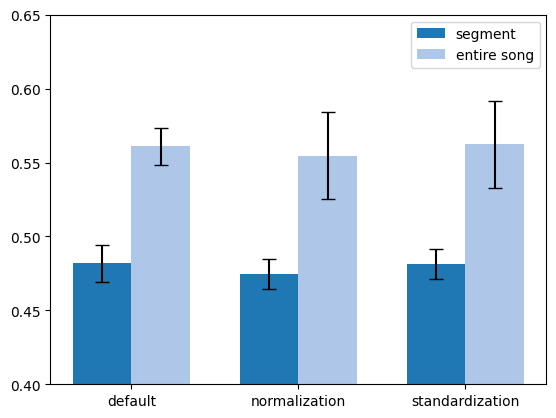

In [ ]:
from re import X
import matplotlib.pyplot as plt
import numpy as np

techniques = ['default', 'normalization', 'standardization']

default =     [0.5698728832005572, 0.58036903673576  , 0.5495335733875631, 0.5576475307375137,  0.5471345858442632]
default_SEG = [0.4855416615804036, 0.5044256746768951, 0.4784963329633077, 0.4720376233259837, 0.46809910734494525]

normalization =     [0.5161666573381344, 0.5439669272436675, 0.5564236273064795,   0.6065809685504083, 0.5491613649508387]
normalization_SEG = [0.4640338917573293, 0.4657036066055298, 0.47083667914072674, 0.49030431111653644, 0.4822896420955658]

standardization =     [0.5932063409143206, 0.5773170519350485, 0.5801955260359335, 0.5489794585719883, 0.5114106606466539]
standardization_SEG = [0.4937039911746979, 0.48712970813115436, 0.4874383012453715, 0.46909366051356, 0.46932249267896015]


default_mean = np.mean(default)
default_std  = np.std(default)
default_SEG_mean = np.mean(default_SEG)
default_SEG_std  = np.std(default_SEG)

normalization_mean = np.mean(normalization)
normalization_std  = np.std(normalization)
normalization_SEG_mean = np.mean(normalization_SEG)
normalization_SEG_std  = np.std(normalization_SEG)

standardization_mean = np.mean(standardization)
standardization_std  = np.std(standardization)
standardization_SEG_mean = np.mean(standardization_SEG)
standardization_SEG_std  = np.std(standardization_SEG)


bar_width = 0.35

color_1 = '#1f77b4'  # Standard blue
color_2 = '#aec7e8'  # Lighter shade of blue


plt.bar(np.arange(len(techniques)) - bar_width/2, [default_SEG_mean, normalization_SEG_mean, standardization_SEG_mean], bar_width, yerr=[default_SEG_std, normalization_SEG_std, standardization_SEG_std], capsize=5, label='segment', color=color_1)
plt.bar(np.arange(len(techniques)) + bar_width/2, [default_mean, normalization_mean, standardization_mean], bar_width, yerr=[default_std, normalization_std, standardization_std], capsize=5, label='entire song', color=color_2)

plt.xticks(np.arange(len(techniques)), techniques, rotation=0)

#plt.xlabel('Data augmentation techniques')
#plt.ylabel('Accuracy')
#plt.title('amount of data augmentation')
plt.ylim(0.4, 0.65)
plt.legend()


#save image
plt.savefig('/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/plot/normalization_techique.png')

plt.show()

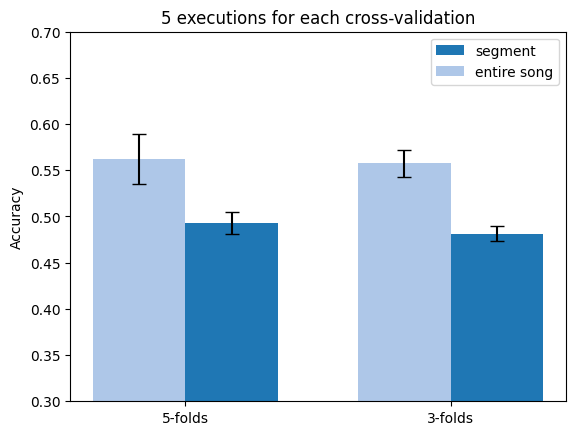

In [ ]:
import matplotlib.pyplot as plt
import numpy as np




techniques = ['5-folds', '3-folds']

acc_5 = [0.561, 0.529, 0.604, 0.539, 0.577]
acc_5_seg = [0.494, 0.484, 0.499, 0.476, 0.510]
acc_5_mean = np.mean(acc_5)
acc_5_std = np.std(acc_5)
acc_5_seg_mean = np.mean(acc_5_seg)
acc_5_seg_std =  np.std(acc_5_seg)


acc_3 = [0.539, 0.545, 0.565, 0.558, 0.580]
acc_3_seg = [0.469, 0.487, 0.481, 0.492, 0.478]
acc_3_mean = np.mean(acc_3)
acc_3_std = np.std(acc_3)
acc_3_seg_mean = np.mean(acc_3_seg)
acc_3_seg_std =  np.std(acc_3_seg)



bar_width = 0.35

color_1 = '#1f77b4'  # Standard blue
color_2 = '#aec7e8'  # Lighter shade of blue

plt.bar(np.arange(len(techniques)) + bar_width/2, [acc_5_seg_mean, acc_3_seg_mean], bar_width, yerr=[acc_5_seg_std, acc_3_seg_std], capsize=5, label='segment', color=color_1)
plt.bar(np.arange(len(techniques)) - bar_width/2, [acc_5_mean, acc_3_mean], bar_width, yerr=[acc_5_std, acc_3_std], capsize=5, label='entire song', color=color_2)


plt.xticks(np.arange(len(techniques)), techniques, rotation=0)

#plt.xlabel('Data augmentation techniques')
plt.ylabel('Accuracy')
plt.title('5 executions for each cross-validation')
plt.ylim(0.3, 0.7)
plt.legend()
plt.show()

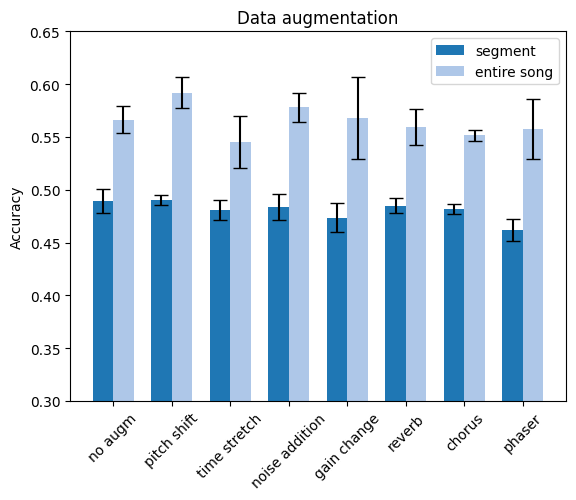

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

techniques = ['no augm','pitch shift','time stretch','noise addition','gain change','reverb','chorus','phaser']

accuracies = [0.5665918311079601, 0.5920621446088339, 0.5453729443542686, 0.578036592722501, 0.5684417827032427, 0.5594948910738383, 0.5516975855685534, 0.5573415548797552]
stds =       [0.012800531944682345, 0.01466224759935574, 0.02481945323744583, 0.013936378411661605, 0.038894428593172284, 0.017000460071701872, 0.005047711381202298, 0.028488047075938758]


acc_segments =  [0.48948788974020213, 0.49036362436082626, 0.4808741344345941, 0.48354280657238435, 0.4738409121831258, 0.48486685421731734, 0.48221466938654584, 0.4618070291148291]
stds_segments = [0.010947213585867008, 0.0043638428331192625, 0.009644828252403856, 0.012326846078053615, 0.01414211385632899, 0.007091327817389596, 0.004680278361318037, 0.010258773962394795]

# Create bar plot
#plt.bar(np.arange(len(categories)) - bar_width/2, values1, bar_width, yerr=std_devs1, capsize=5, label='Bar 1')
#plt.bar(np.arange(len(categories)) + bar_width/2, values2, bar_width, yerr=std_devs2, capsize=5, label='Bar 2')

bar_width = 0.35

color_1 = '#1f77b4'  # Standard blue
color_2 = '#aec7e8'  # Lighter shade of blue

plt.bar(np.arange(len(techniques)) - bar_width/2, acc_segments, bar_width, yerr=stds_segments, capsize=5, label='segment', color=color_1)
plt.bar(np.arange(len(techniques)) + bar_width/2, accuracies, bar_width, yerr=stds, capsize=5, label='entire song', color=color_2)

plt.xticks(np.arange(len(techniques)), techniques, rotation=45)

#plt.xlabel('Data augmentation techniques')
plt.ylabel('Accuracy')
plt.title('Data augmentation')
plt.ylim(0.3, 0.65)
plt.legend()

# save if needed
# ...

plt.show()

## LISTENING TEST

In [ ]:
# useful libraries
from IPython.display import Audio
import soundfile as sf
import librosa
import numpy as np
import pickle

### select the songs for the listening test

In [ ]:
# select the songs for the experiment
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from collections import Counter
import json


def get_best_and_difference_with_second_best(list_of_emotions):

    # verify that I have at lest two values in the list
    if len(list_of_emotions) < 2:
        raise ValueError("list should have at least two elements")

    # get the maximum value
    max_val = max( list_of_emotions )

    # get a new list without the maximum value(s)
    new_list = [i for i in list_of_emotions if i!=max_val]

    # check the new list length
    if len(new_list) < len(list_of_emotions) - 1:

        # if two or more values were deleted it menas that the second best is as the first
        second_max = max_val
    else:

        # get the max form the list without the best
        second_max = max( new_list ) if new_list else max_val

    difference = max_val - second_max
    return max_val, difference


def plot_bar(values, title=False):

    #count
    counts = Counter(values)
    elements= list(counts.keys())
    frequencies = list(counts.values())

    #plot
    plt.figure(figsize=(10, 6))
    plt.bar(elements, frequencies, color='skyblue', edgecolor='black')
    plt.xlabel('Element')
    plt.ylabel('Frequency')
    if title: plt.title(title)
    plt.show()


# not ideal if i want to plot the occurrences of each element
def plot_histogram(lista, title=False):

    plt.figure(figsize=(8, 5))
    plt.hist(lista, bins=50, edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    #plt.xticks(range(min(lista), max(lista) + 1))
    if title: plt.title(title)
    plt.show()


def print_occurences(value_list):

    counts = Counter(value_list)

    for key, value in counts.items():
        print(EMOTIONS[key], value)



62_aggressive_2_steelstring-guitar_AdoLaV_pick_new8_20200619.wav
[25, -19, 11, -11] ->  aggressive 

146_aggressive_2_steelstring-guitar_AleMar_pick_new9_20200724.wav
[22, -31, -10, 3] ->  aggressive 

380_aggressive_1_steelstring-guitar_AngLoi_pick_new3_20200917.wav
[15, -18, 2, -6] ->  aggressive 

261_aggressive_2_steelstring-guitar_AntPao_pick_new9_20200801.wav
[24, -28, -8, 2] ->  aggressive 

249_aggressive_2_classical-guitar_CesSam_fingers_new4_20200720.wav
[30, -33, -20, 3] ->  aggressive 

14_aggressive_2_steelstring-guitar_DavBen_pick_new4_20200623.wav
[25, -20, -2, 8] ->  aggressive 

178_aggressive_3_steelstring-guitar_FilMel_fingers_new6_20200729.wav
[17, -5, 4, -3] ->  aggressive 

310_aggressive_3_steelstring-guitar_GioDic_pick_new5_20200821.wav
[33, -31, -12, 5] ->  aggressive 

160_aggressive_1_steelstring-guitar_MasChi_pick_new5_20200729.wav
[29, -17, -3, 3] ->  aggressive 

38_aggressive_2_steelstring-guitar_OweWin_pick_new5_20200629.wav
[35, -35, -4, 1] ->  aggressi

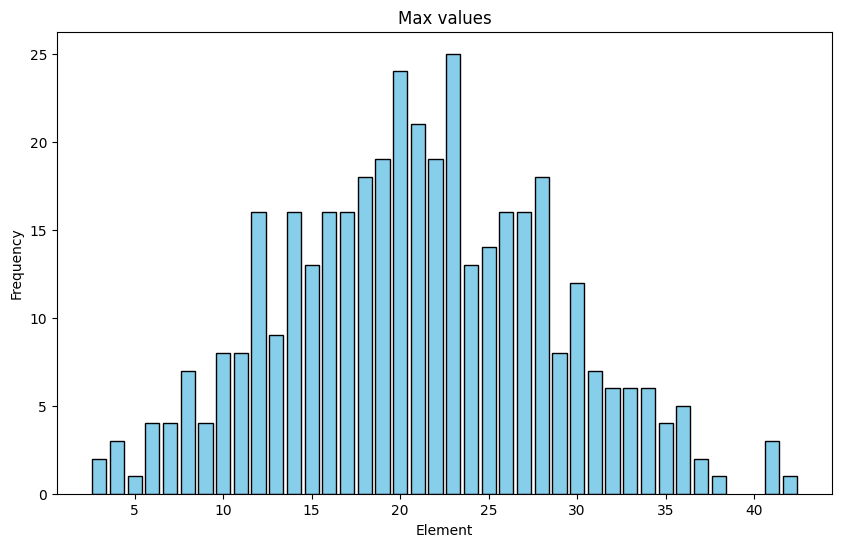

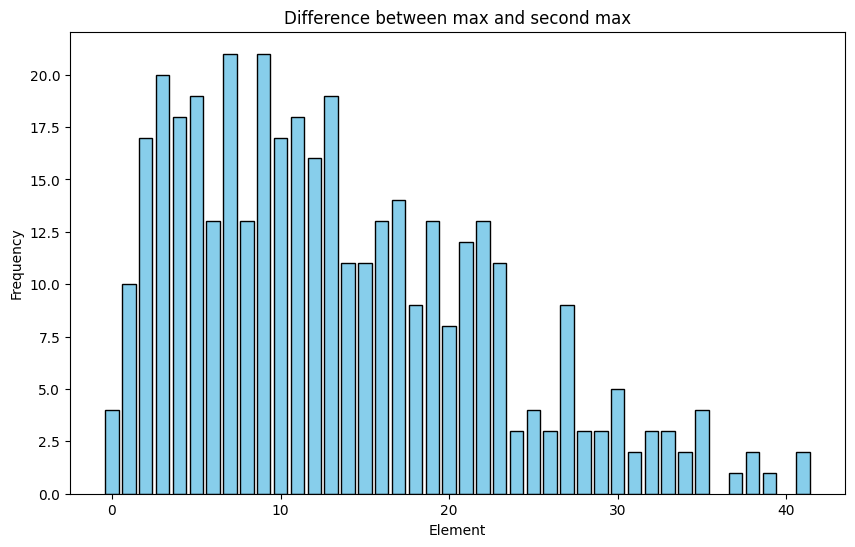

In [ ]:

LISTEN_PATH = r'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/0__files_to_choose_songs/anonymous-results_of-listening-test.csv'
EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']



# list to store values of the highest emotion and difference with 2nd highest
max_vals = []
differences = []

# to store the files that are not ambigous (e.g., diff > 12)
files_for_test_robust = {
    'file_name': [],
    'emotion':[]
    }


df = pd.read_csv(LISTEN_PATH)


# save all the file names in a list
file_names = df['file_name'].unique().tolist()

# for each file name get the 16 evaluations ad sum the emotion values
for file_name in file_names:

    # get the 16 evaluations for this specific audio file
    evaluations = df[ df['file_name'] == file_name ]

    # sum the values for each emotions an take the higher
    sum_for_each_emotion = [0, 0, 0, 0]   # ['aggressive', 'relaxed', 'happy', 'sad']
    for i, emotion in enumerate(EMOTIONS):
        sum_for_each_emotion[i] = evaluations[emotion].sum()

        # take the mean among the 16 participants
        #sum_for_each_emotion = [i/16 for i in sum_for_each_emotion]

    # verify if I have two emotions with the same max value...
    max_value = max(sum_for_each_emotion)
    how_may_max = sum_for_each_emotion.count(max_value)

    #we need to take audio files that are not ambiguous
    # consider the difference between the most rated emotion and the second best

    # get max value and the difference with the second max value
    max_val, difference = get_best_and_difference_with_second_best(sum_for_each_emotion)

    # get the most rated emotion (note: it gets the first if more emotions have the same rating)
    emotion = np.argmax(sum_for_each_emotion)

    max_vals.append(max_val)
    differences.append(difference)

    # store files that are not ambiguous (e.g., with difference > 12, that is the median of differences)
    if difference > 12:

        higher_emotion = np.argmax(sum_for_each_emotion)
        files_for_test_robust['file_name'].append(file_name)
        files_for_test_robust['emotion'].append(higher_emotion)


        print(file_name)
        print(sum_for_each_emotion, '-> ',  EMOTIONS[higher_emotion]  ,'\n')
    #print(f"emotion: {emotion}, max: {max_value}, difference: {difference} - {file_name}")


# * new: plot hist
plot_bar(max_vals, title='Max values')

plot_bar(differences, title='Difference between max and second max')

# store robust files in json file
#LISTENING_TEST_PATH_ROBUST = r'...'
#with open(LISTENING_TEST_PATH_ROBUST, "wb") as fb:
#    pickle.dump(files_for_test_robust, fb)

In [ ]:
np.percentile(differences, 25)

6.0

### Create augmented samples

In [ ]:
# create an augmented sample with the 15 possibilities: 10 techniques (time shift is excluded), some of them with two wxtremes (e.g., pitch shift -3 and +3)
!pip install pedalboard
from pedalboard import Pedalboard, Chorus, Reverb, Distortion, Phaser, Delay, load_plugin, LowpassFilter, HighpassFilter, Compressor, Resample
import librosa
import numpy as np

#SAMPLING_RATE = 44100


def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal

def apply_pedalboard_effect(sample, effect, value):
    if effect=='reverb': board = Pedalboard( [ Reverb(value)] )
    if effect=='saturation': board = Pedalboard( [ Distortion(value)] )
    if effect=='low_pass': board = Pedalboard( [ LowpassFilter(cutoff_frequency_hz=value)] )
    if effect=='high_pass': board = Pedalboard( [ HighpassFilter(cutoff_frequency_hz=value)] )
    if effect=='compressor': board = Pedalboard( [ Compressor(threshold_db = -20, ratio=value)] )
    if effect=='resampling': board = Pedalboard( [ Resample(value)] )

    augmented_signal = board(sample, SAMPLING_RATE)
    return augmented_signal



def apply_augmentation(sample, name):
    # pitch shift [-3, 3]
    if name=='pitch_shift_low':
        augmented_sample = librosa.effects.pitch_shift(y=sample, sr=SAMPLING_RATE, n_steps=-3)
    if name=='pitch_shift_high':
        augmented_sample = librosa.effects.pitch_shift(y=sample, sr=SAMPLING_RATE, n_steps=+3)

    # time stretch [0.97, 1.03]
    if name=='time_stretch_low':
        augmented_sample = librosa.effects.time_stretch(y=sample, rate=0.97)
    if name=='time_stretch_high':
        augmented_sample = librosa.effects.time_stretch(y=sample, rate=1.03)

    # noise addition [0, 0.05]
    if name=='noise_addition':
        augmented_sample = add_white_noise(signal=sample, noise_percentage_factor=0.05)

    # reverb [0, 0.1]
    if name=='reverb':
        augmented_sample = apply_pedalboard_effect(sample, effect='reverb', value=0.1)

    # saturation [0, 20]
    if name=='saturation':
        augmented_sample = apply_pedalboard_effect(sample, effect='saturation', value=20)

    # low-pass [500, 5000]
    if name=='low_pass':
        augmented_sample = apply_pedalboard_effect(sample, effect='low_pass', value=500)

    # high-pass [200, 2000]
    if name=='high_pass':
        augmented_sample = apply_pedalboard_effect(sample, effect='high_pass', value=2000)

    # compression [1, 4]
    if name=='compressor':
        augmented_sample = apply_pedalboard_effect(sample, effect='compressor', value=4)

    # resampling [11025, 22050]
    if name=='resampling':
        augmented_sample = apply_pedalboard_effect(sample, effect='resampling', value=11025)



    return augmented_sample


def normalize_loudness(audio_file, sr, loudness_level=-26, verbose=False):
    # create BS.1770 meter and get audio loudness
    meter = pyln.Meter(sr)
    loudness = meter.integrated_loudness(audio_file)
    # loudness normalize to -26 dB LUFS
    loudness_normalized_audio = pyln.normalize.loudness(audio_file, loudness, loudness_level)
    if verbose:
        print(f"\nDETAILS OF normalized_audio FUNCTION\n"
              f"- old loudness: {loudness}\n"
              f"- new loudness: {meter.integrated_loudness(loudness_normalized_audio)}")
    return loudness_normalized_audio



In [ ]:
#!pip install pyloudnorm


from IPython.display import Audio
import soundfile as sf
import pyloudnorm as pyln


AUGMENTATIONS = ['pitch_shift_low', 'pitch_shift_high', 'time_stretch_low', 'time_stretch_high', 'noise_addition', 'reverb','saturation', 'low_pass','high_pass', 'compressor', 'resampling']
INITIAL_DURATION = 8.5
FINAL_DURATION = 8

# SAMPLING_RATE = 22050

# new - take high quality segments for the listening test
SAMPLING_RATE = 44100

emotion = 'sad'

# load example audio file

# 1' round
#if emotion=='aggressive': audio_path = r'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/2__audio_files_used/1__/308_aggressive_i1_steelstring-guitar_GioDic_fingers_20200821.wav'
#if emotion=='relaxed': audio_path = r'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/2__audio_files_used/1__/7_relaxed_i1_steelstring-guitar_LucTur_pick_20200625.wav'
#if emotion=='happy': audio_path = r'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/2__audio_files_used/1__/138_happy_i3_steelstring-guitar_SamLor_pick_20200715.wav'
#if emotion=='sad': audio_path = r'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/2__audio_files_used/1__/355_sad_i3_classical-guitar_NicLat_fingers_20200730.wav'

# 2' round
if emotion=='aggressive': audio_path = r'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/2__audio_files_used/2__/213_aggressive_i2_classical-guitar_SalOli_pick_20200714.wav'
if emotion=='relaxed': audio_path = r'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/2__audio_files_used/2__/244_relaxed_i3_classical-guitar_FedCer_fingers_20200714.wav'
if emotion=='happy': audio_path = r'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/2__audio_files_used/2__/53_happy_i2_steelstring-guitar_ValFui_fingers_20200627.wav'
if emotion=='sad': audio_path = r'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/2__audio_files_used/2__/377_sad_i1_classical-guitar_AngLoi_fingers_20200917.wav'

sample, _ = librosa.load(audio_path, duration=INITIAL_DURATION, sr=SAMPLING_RATE)

# new - normalize sample for subsiquent augmentations
normalized_sample = normalize_loudness(sample, SAMPLING_RATE, loudness_level=-26, verbose=False)

# normalize and cut sample for saving the clean one
normalized_sample_cut = normalize_loudness(sample[:FINAL_DURATION * SAMPLING_RATE], SAMPLING_RATE, loudness_level=-26, verbose=False)

# export original track
output_path = f'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/3__augmented_8_seconds_44100/0__{emotion}2_original.wav'
sf.write(output_path, normalized_sample_cut, SAMPLING_RATE)


# apply each augmentation to the audio file
for augmentation in AUGMENTATIONS:

    # define output path
    output_path = f'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/3__augmented_8_seconds_44100/{emotion}2_{augmentation}.wav'

    # apply augmentation
    augmented_sample = apply_augmentation(normalized_sample, name=augmentation)

    # new normalize after augm -> note: done for listening purposes, in the paper the audio files
    # are not normalized after the augmentation from what I see from the code

    # cut the sample at final duration (8 sec) before the normalization takes place
    augmented_sample = augmented_sample[:FINAL_DURATION * SAMPLING_RATE]

    augmented_sample_normalized = normalize_loudness(augmented_sample, SAMPLING_RATE, loudness_level=-26, verbose=False)

    # write augmentaed sample
    sf.write(output_path, augmented_sample_normalized, SAMPLING_RATE)

# listen
#Audio(data=augmented_sample, rate=22050, autoplay=True)

In [ ]:
_

44080

In [ ]:
audio_path = '/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/2__audio_files_used/2__/377_sad_i1_classical-guitar_AngLoi_fingers_20200917.wav'

sample, _ = librosa.load(audio_path, duration=8.5, sr=SAMPLING_RATE)
aug_sample = apply_augmentation(sample, name='time_stretch_high')   #'time_stretch_high'

In [ ]:
len(aug_sample) /22050

8.252426303854875

In [ ]:
sample = sample[:7*22050]

In [ ]:
from IPython.display import Audio
Audio(data=sample, rate=22050, autoplay=True)

In [ ]:

#audio_path = r'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/308_aggressive_i1_steelstring-guitar_GioDic_fingers_20200821.wav'

#audio_path = r'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/7_relaxed_i1_steelstring-guitar_LucTur_pick_20200625.wav'

#audio_path = r'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/138_happy_i3_steelstring-guitar_SamLor_pick_20200715.wav'

audio_path = r'/content/drive/MyDrive/Colab Notebooks/7__emotion_augmentation/0__listening_test/355_sad_i3_classical-guitar_NicLat_fingers_20200730.wav'


sample, _ = librosa.load(audio_path, duration=8, sr=SAMPLING_RATE)
#listen
Audio(data=sample, rate=22050, autoplay=True)